### Power and coherence are dynamic

In [ ]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.stats import fdr_correction
from PIL import Image
from scipy.signal import fftconvolve
from tqdm import tqdm
from utils import *

from config import get_dates, return_delay_split
from GDa.flatmap.flatmap import flatmap
from GDa.graphics import plot
from GDa.loader import loader

##### Setting configurations

In [3]:
_ROOT = os.path.expanduser("~/funcog/gda/")

In [ ]:
metric = "coh"
monkey = "lucy"
ds = 1

In [ ]:
early_cue, early_delay = return_delay_split(monkey, delay_type=ds)

In [ ]:
sessions = get_dates(monkey)

In [ ]:
stages = [[-0.4, 0], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

##### Auxiliar functions

In [ ]:
import numba


def xr_w_score(data):
    return (data - data.mean("times")) / data.std("times")


@numba.njit
def _histogram(x, bins):
    return np.histogram(x, bins=np.linspace(-3, 3, 20))[0]


def signal_entropy(power):

    bins = np.linspace(-3, 3, 20)
    nbins = len(bins)

    counts = np.apply_along_axis(_histogram, -1, power, bins=bins)

    pk = counts / counts.sum(-1)[..., np.newaxis]

    H = stats.entropy(pk, qk=None, base=None, axis=-1) / np.log(nbins)
    H = xr.DataArray(
        H,
        dims=("roi", "freqs", "trials"),
        coords=(power.roi, power.freqs, power.trials),
    )

    return H

In [9]:
def compute_time_series_cv(data, nbins=10):
    """
    Compute the coefficient of variation (CV) of a time series.

    The CV is defined as the standard deviation divided by the mean of the time series. This function also computes a confidence interval for the CV at a specified level.

    Parameters
    ----------
    data : xarray.DataArray
        The time series data. It should have dimensions 'roi', 'trials', and 'times'.

    Returns
    -------
    cv : xarray.DataArray
        The coefficient of variation of the time series data. It has dimensions 'roi', 'trials', and 'times'.
    """
    cv = signal_entropy(data)  # data.std("times") / data.mean("times")
    return confidence_interval(cv, cis=95, axis=2, n_boots=1000, verbose=False)

In [10]:
data_loader = loader(_ROOT=_ROOT)

In [11]:
colors = dict(
    zip(
        [
            "motor",
            "parietal",
            "prefrontal",
            "somatosensory",
            "temporal",
            "visual",
            "auditory",
        ],
        ["r", "aqua", "b", "m", "goldenrod", "green", "brown"],
    )
)

#### Figure 1

In [12]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=True, monkey=monkey
)

In [13]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)

In [14]:
def plot_circles(ax):
    """
    Plot task scheme.
    """

    png = plt.imread("figures/task.png")
    plt.sca(ax)
    im = plt.imshow(png, interpolation="none")
    plt.axis("off")


def plot_brain_areas(ax):

    import matplotlib as mpl
    import matplotlib.patches as mpatches

    areas_dict = get_areas()

    area_no = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    areas = np.asarray([area for area in areas_dict.keys()])
    values = np.asarray([area_no[region] for region in areas_dict.values()])
    color = [colors[region] for region in areas_dict.values()]

    fmap = flatmap(values, areas)

    fmap.plot(
        ax, ax_colorbar=None, cbar_title=None, alpha=0.4, colormap=None, colors=color
    )


def plot_power(ax, roi):
    plt.sca(ax)
    power = power_task.sel(times=slice(-0.5, 0)).interp(
        freqs=np.linspace(3, 75, 20), method="linear"
    )
    power_st = power.sel(roi=roi).mean("times")
    power_mean = power.sel(roi=roi).mean(("times", "trials"))

    power_st.plot(x="freqs", hue="trials", color="b", lw=0.05)
    power_mean.plot(x="freqs", hue="trials", color="k")
    ax.get_legend().remove()
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]


def plot_ts_power(ax, roi, showfreqs=False, showscale=False, showepochs=False):
    plt.sca(ax)

    import matplotlib as mpl

    cmap = mpl.cm.get_cmap("viridis", 10)
    color_list = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    power = power_task.sel(roi=roi, trials=100)
    power = (power - power.mean("times")) / power.std("times")

    freqs = power.freqs.data.astype(int)

    for i in range(10):
        (power[i] + 3 * i).plot(x="times", hue="trials", color=color_list[i], lw=0.5)
        if showfreqs:
            plt.text(2.05, 2.9 * i, f"{freqs[i]} Hz", rotation=30)
        if showscale:
            if i == 9:
                plt.hlines(-0.9, -0.5, 0, color="k")
                plt.vlines(-0.5, -0.9, -0.9 + 3, color="k", lw=3)
                plt.text(-0.5, -2.5, "500 ms", fontsize=8)
                plt.text(-0.65, 0, r"3$\sigma$", rotation=90, fontsize=8)
    plt.xlim([-0.5, 2])

    plt.vlines(0, -0.9, 30, color="k", lw=1)
    plt.vlines(0.5, -0.9, 30, color="k", lw=1)
    plt.vlines(1.5, -0.9, 30, color="k", lw=1)
    if showepochs:

        plt.hlines(31, -0.4, 0, color="k", lw=1)
        plt.hlines(31, 0, 0.4, color="g", lw=1)
        plt.hlines(31, 0.5, 0.9, color="b", lw=1)
        plt.hlines(31, 0.9, 1.3, color="r", lw=1)
        plt.hlines(30, 1.1, 1.5, color="purple", lw=1)

        plt.text(-0.2, 31.5, "P", fontsize=8)
        plt.text(0.15, 31.5, "S", fontsize=8)
        plt.text(0.67, 31.5, "D1", fontsize=8)
        plt.text(1.04, 31.5, "D2", fontsize=8)
        plt.text(1.25, 29.1, "Dm", fontsize=8)

    [ax.spines[key].set_visible(False) for key in ["top", "right", "left"]]

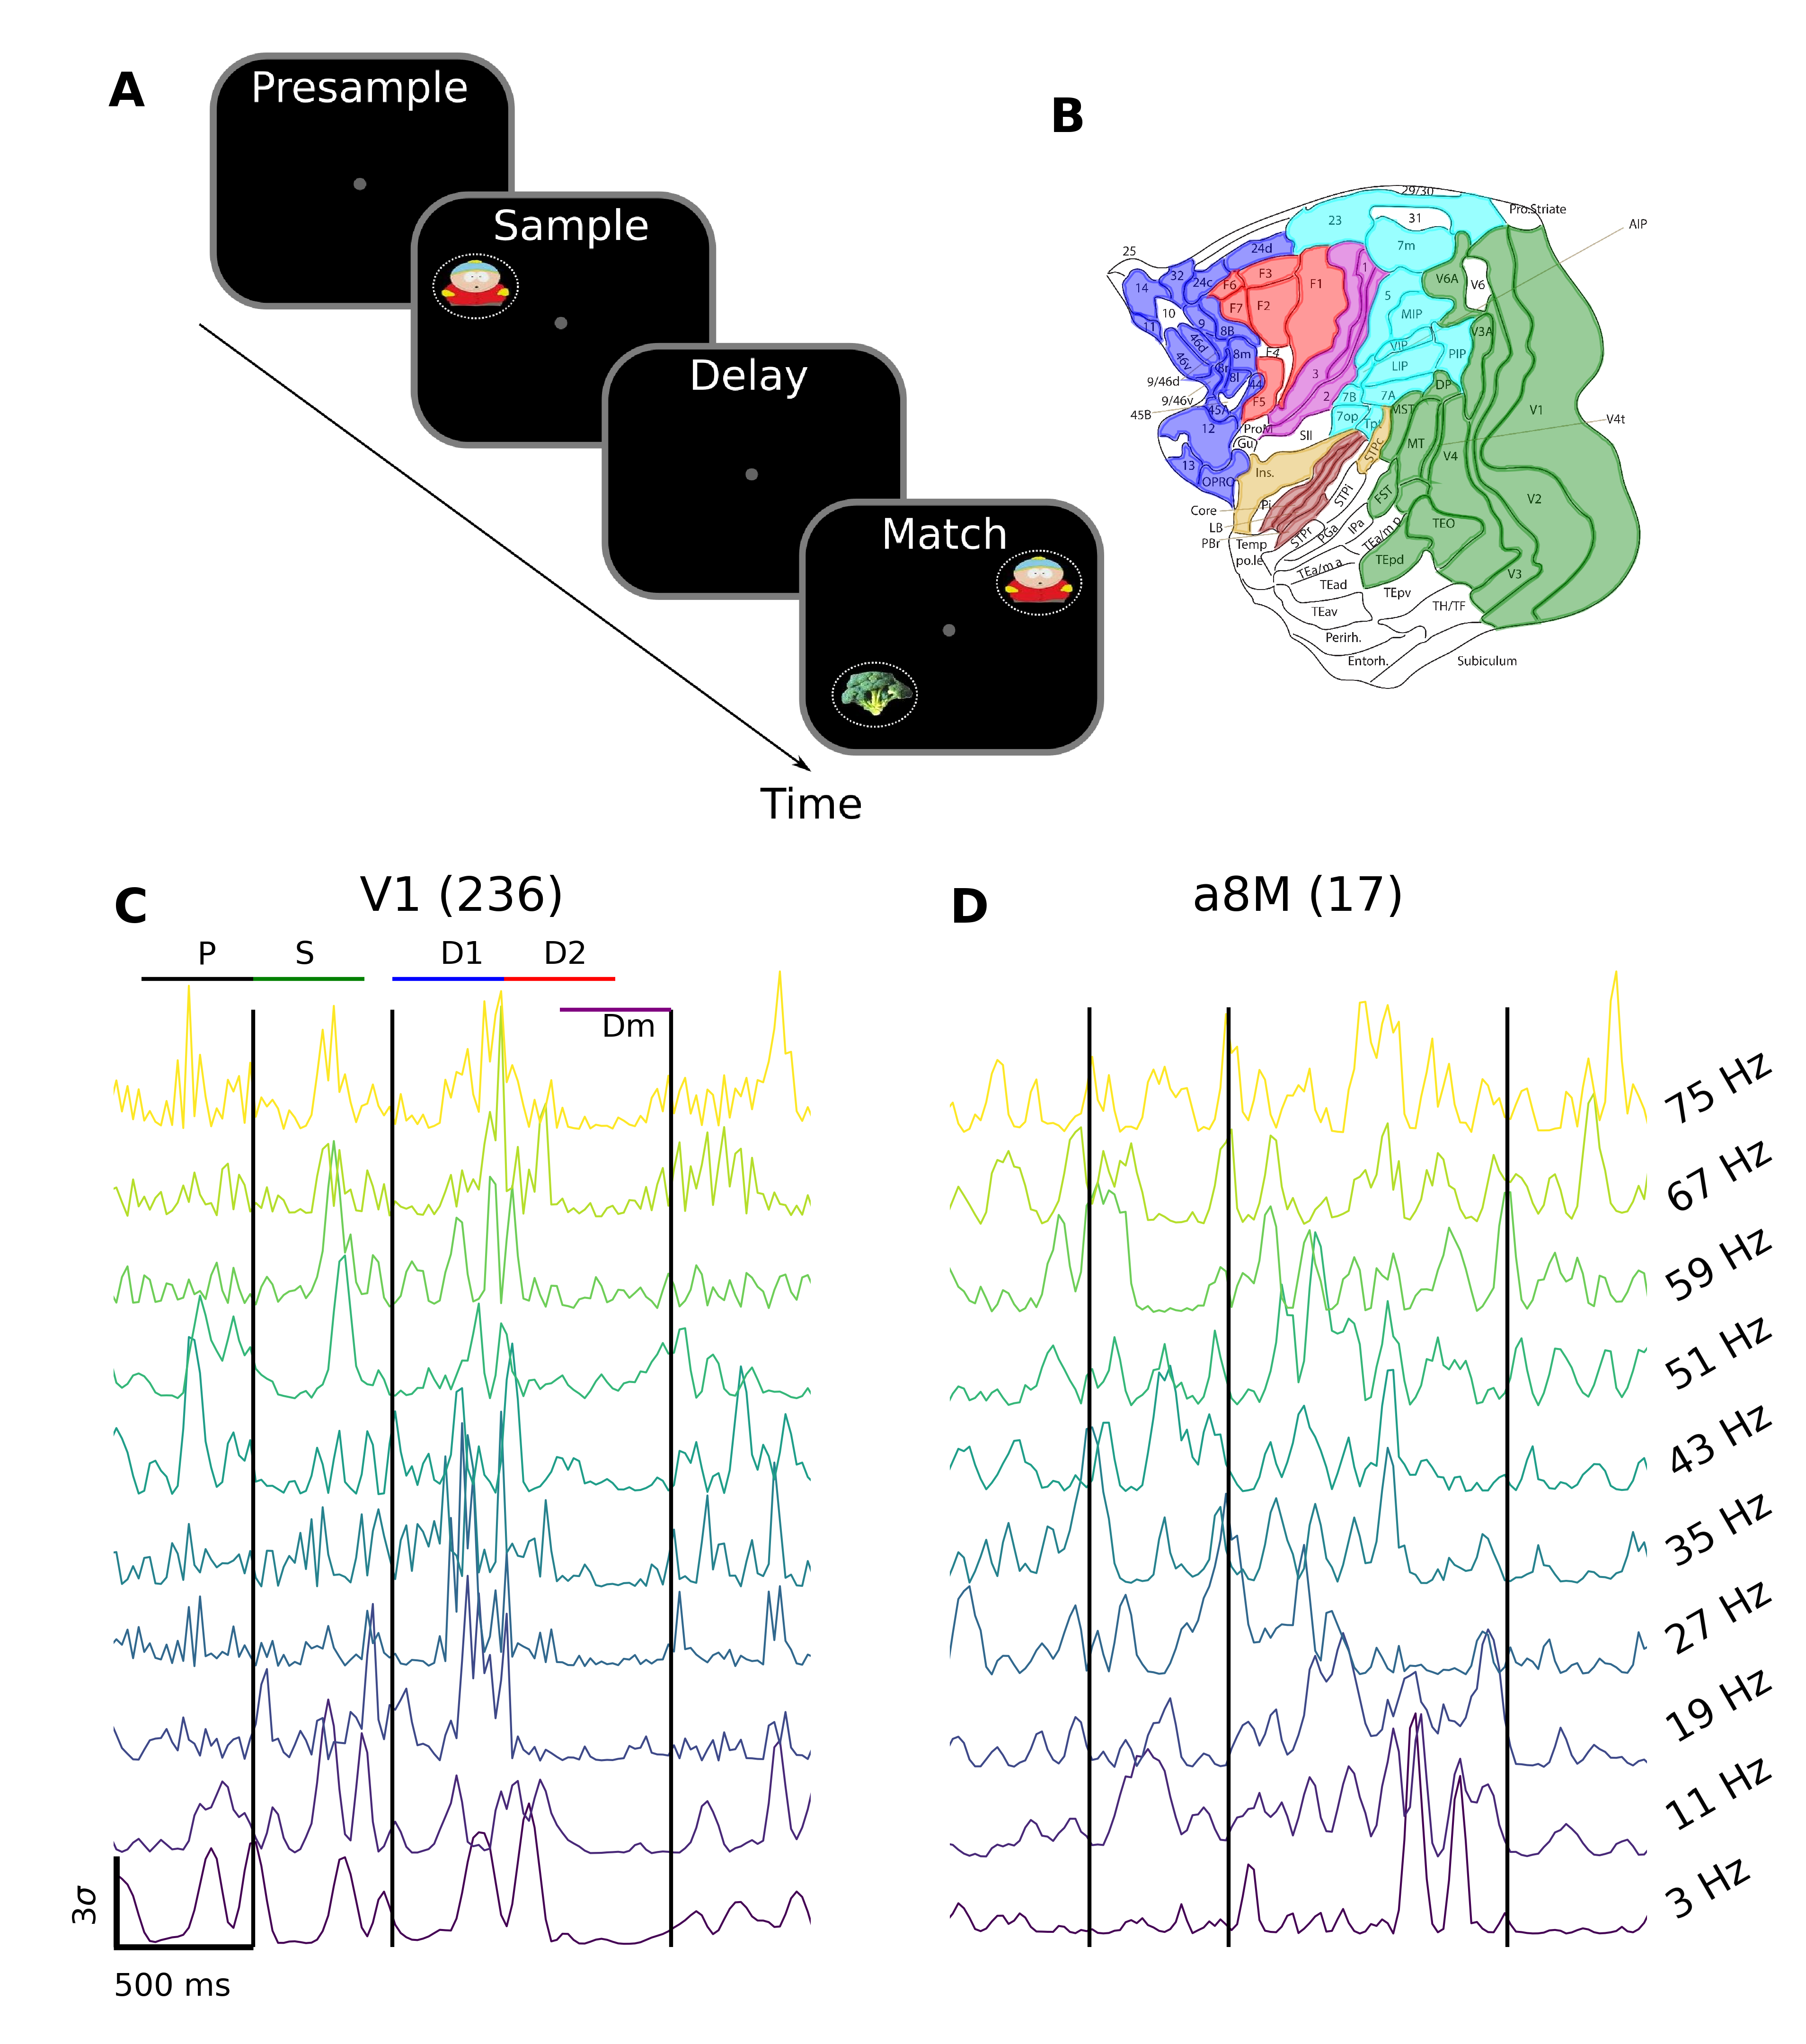

In [15]:
fig = plt.figure(figsize=(6, 7), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.1,
    right=0.95,
    wspace=0,
    bottom=0.60,
    top=0.99,
    width_ratios=[1, 0.6],
)
gs1 = fig.add_gridspec(
    nrows=1,
    ncols=2,
    left=0.05,
    right=0.95,
    hspace=0.4,
    bottom=0.01,
    top=0.55,
)

ax0 = plt.subplot(gs0[0])
plot_circles(ax0)
ax1 = plt.subplot(gs0[1])
plot_brain_areas(ax1)

#######################
ax2 = plt.subplot(gs1[0])
plot_ts_power(ax2, "V1 (236)", showscale=True, showepochs=True)
plt.title("V1 (236)", pad=3)
plt.axis("off")

#######################
ax3 = plt.subplot(gs1[1])
plot_ts_power(ax3, "a8M (17)", showfreqs=True)
plt.title("a8M (17)", pad=3)
plt.axis("off")

plot.add_panel_letters(
    fig,
    axes=[ax0, ax1, ax2, ax3],
    fontsize=12,
    xpos=[
        -0.1,
        -0.1,
        -0.0,
        -0.0,
    ],
    ypos=[0.93, 1.1, 1.0, 1.0],
)

bg = plot.Background(visible=False)
plt.savefig("figures/n1/figure1.pdf", bbox_inches="tight")

##### Figure 2 - Single Session

In [16]:
kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False, monkey=monkey
)

In [17]:
power_task = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1)
power_fix = data_loader.load_power(**kw_loader, trial_type=2, behavioral_response=0)

In [18]:
_, rois, freqs, times = power_task.coords.values()

In [19]:
# Get the region name for each roi
areas_dict = get_areas()
regions = np.asarray([areas_dict[roi.lower()] for roi in rois.data])

In [20]:
z_power_task = xr_w_score(power_task)
z_power_fix = xr_w_score(power_fix)

cv_task = compute_time_series_cv(z_power_task)
cv_fix = compute_time_series_cv(z_power_fix)

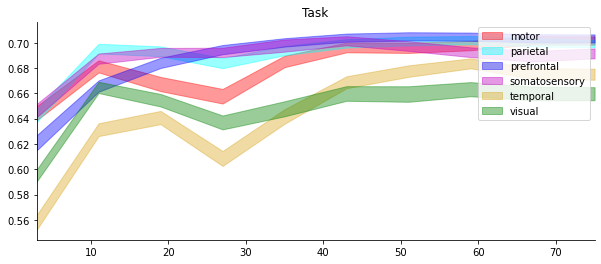

In [21]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)

x = cv_task.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()
y = cv_fix.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()

for r in np.unique(regions):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()

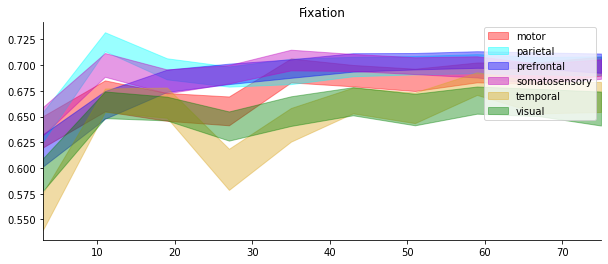

In [22]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(regions):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Fixation")
plt.legend()

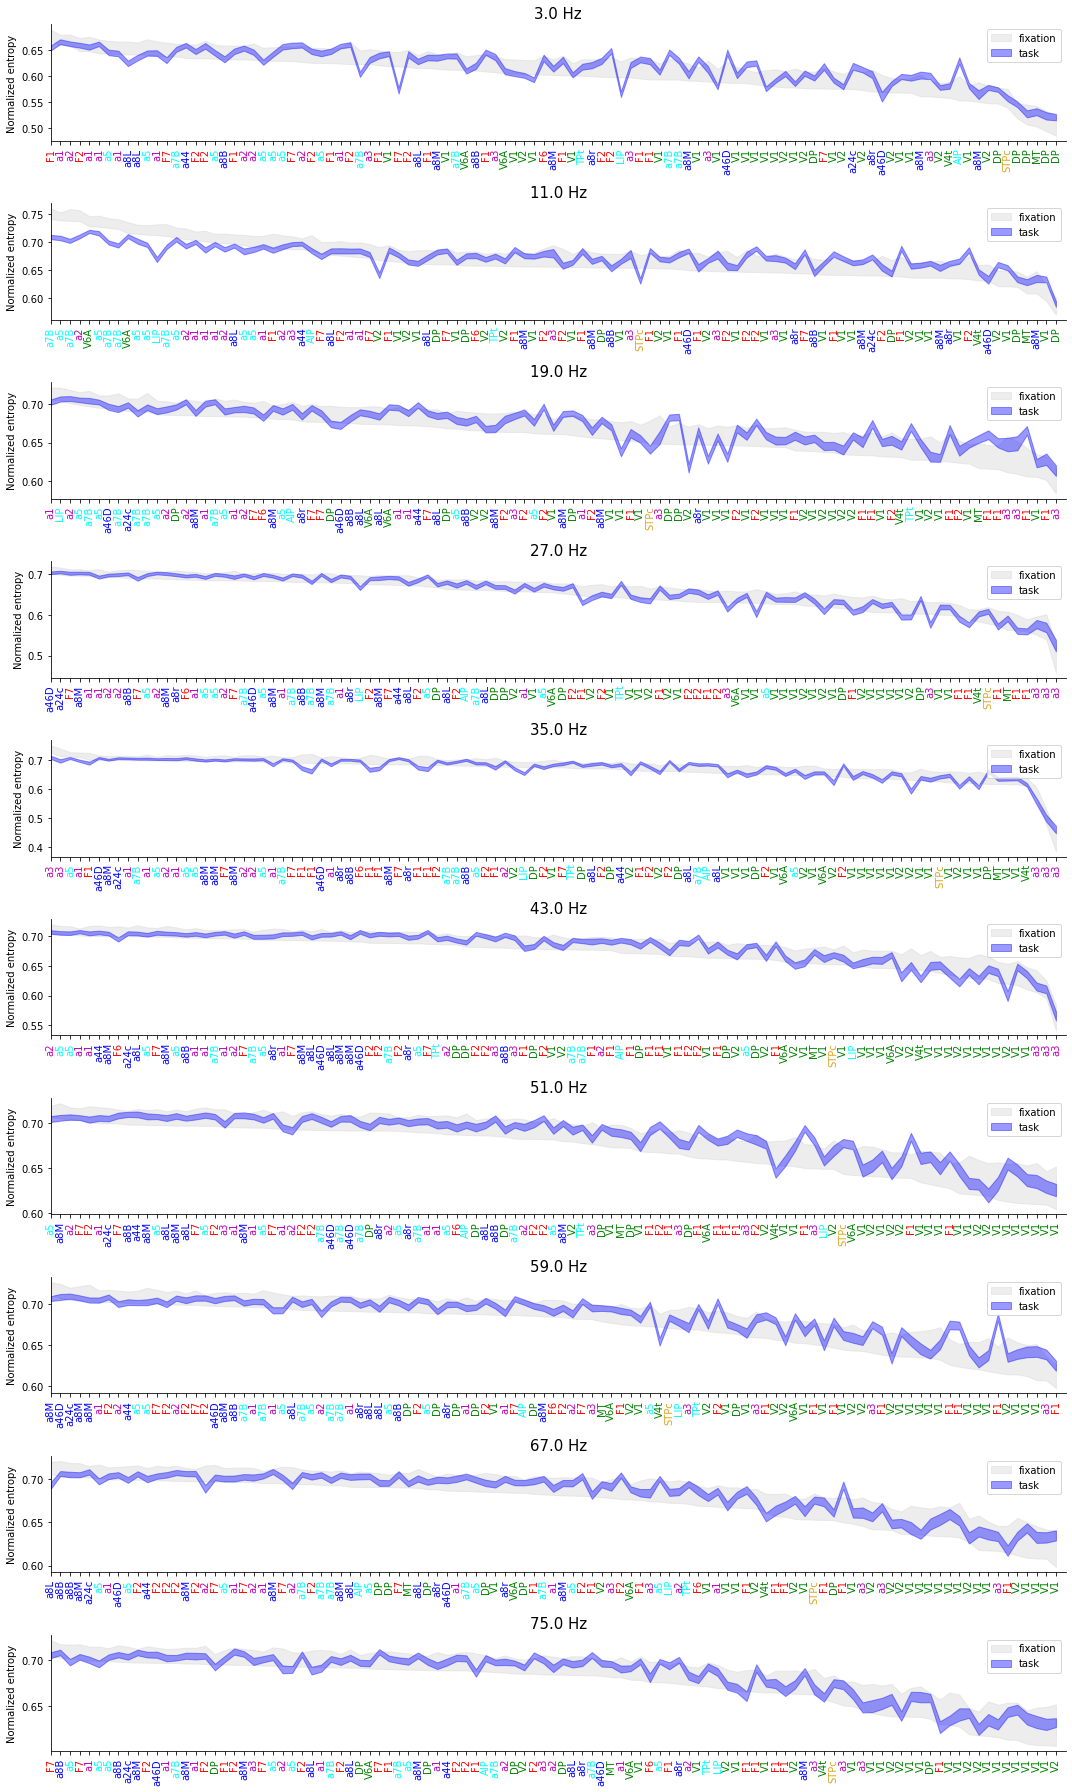

In [23]:
plt.figure(figsize=(15, 25))
freqs = power_task.freqs.data
for fi, freq in enumerate(freqs):

    ax = plt.subplot(10, 1, fi + 1)
    # Fixation
    lower = cv_fix.squeeze().sel(bound="low", freqs=freq)
    higher = cv_fix.squeeze().sel(bound="high", freqs=freq)
    idx = np.argsort(lower)[::-1].data
    plt.fill_between(range(105), lower[idx], higher[idx], color="lightgrey", alpha=0.4)
    # Task
    lower = cv_task.squeeze().sel(bound="low", freqs=freq)
    higher = cv_task.squeeze().sel(bound="high", freqs=freq)
    plt.fill_between(range(105), lower[idx], higher[idx], color="b", alpha=0.4)
    tks = plt.xticks(range(105), rois.data[idx], rotation=90)
    [tks[1][i].set_color(colors[r]) for i, r in enumerate(regions[idx])]
    plt.legend(["fixation", "task"])
    plt.xlim([0, 105])
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.ylabel("Normalized entropy")
    plt.title(f"{freq} Hz", fontsize=15)
plt.tight_layout()
plt.savefig(f"figures/n1/cv_dist_single_session.pdf", dpi=600)

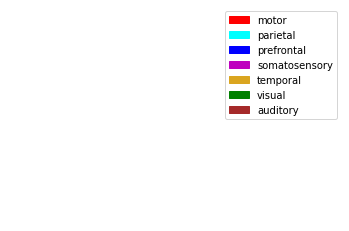

In [24]:
import matplotlib.patches as mpatches

patches = []
for key in colors.keys():
    patches += [mpatches.Patch(color=colors[key], label=key)]
plt.legend(handles=patches)
plt.axis("off")
plt.savefig(f"figures/n1/regions_colors.pdf", dpi=600)

In [25]:
def compute_power_pval(power_task, power_fix, stages):
    pvals = []
    for t0, t1 in stages:
        _, temp = stats.kruskal(
            power_fix.sel(times=slice(t0, t1)),
            power_task.sel(times=slice(t0, t1)),
            axis=(2, 3),
        )
        pvals += [temp]

    pvals, _ = fdr_correction(np.stack(pvals, -1), alpha=0.0001)
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(power_fix.roi, freqs, stage_labels),
    )

    return pvals


def compute_crackle_pval(raster_task, raster_fix, stages):
    pvals = []
    for i in range(raster_task.sizes["times"]):
        _, temp = stats.kruskal(
            raster_fix.isel(times=i),
            raster_task.isel(times=i),
            axis=2,
        )
        pvals += [temp]

    pvals, _ = fdr_correction(np.stack(pvals, -1), alpha=0.0001)
    pvals = xr.DataArray(
        pvals,
        dims=("roi", "freqs", "times"),
        coords=(raster_task.roi, freqs, stage_labels),
    )

    return pvals


def plot_tile_maps(values, regions, vmin=0, vmax=0.8, cmap="viridis"):
    idx = np.argsort(regions)

    for i in range(values.sizes["times"]):

        plt.subplot(1, len(stages), i + 1)

        plt.imshow(
            values.isel(times=i)[idx],
            aspect="auto",
            origin="lower",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )

        if i == 0:
            tks = plt.yticks(range(len(values.roi)), values.roi.data[idx])
            [tks[1][j].set_color(colors[r]) for j, r in enumerate(regions[idx])]
        else:
            plt.yticks([])

        plt.xticks(range(len(freqs)), values.freqs.data.astype(int), rotation=90)
        plt.xlabel("Hz")
        plt.title(f"{values.times[i].data}")

In [26]:
power_pvals = compute_power_pval(power_task, power_fix, stages)

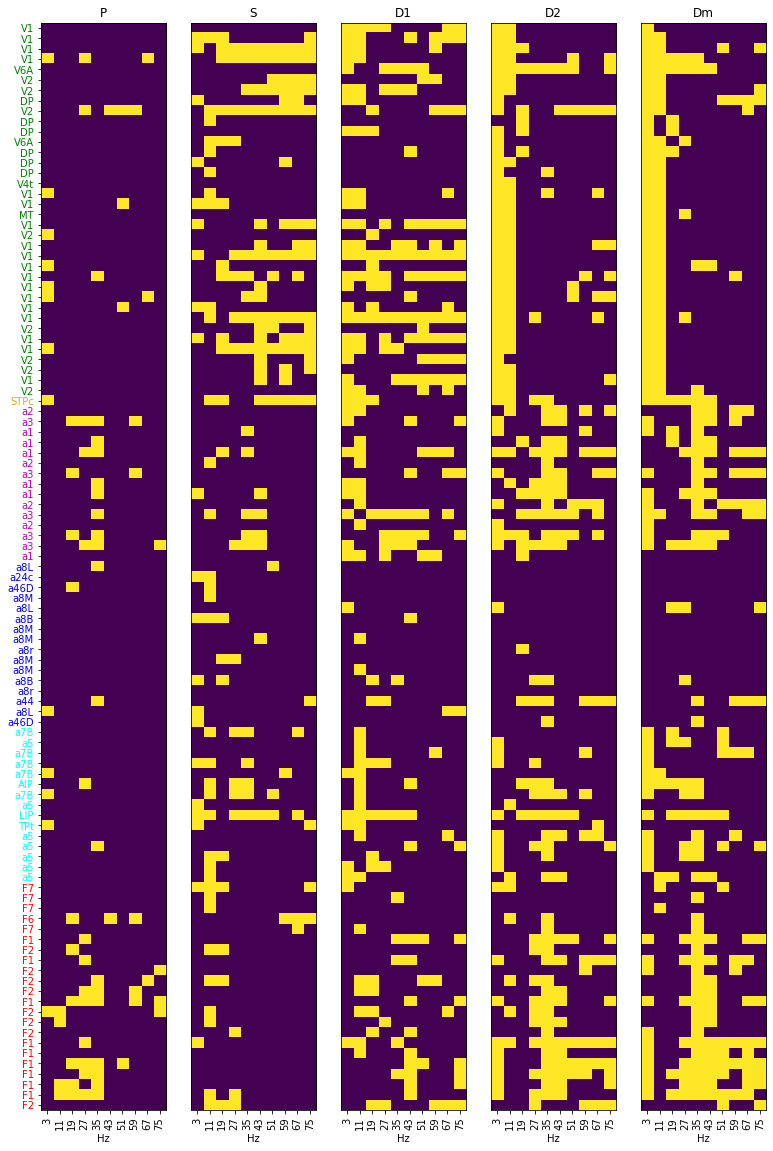

In [27]:
plt.figure(figsize=(13, 20))
plot_tile_maps(power_pvals, regions)

In [28]:
thr_fix = power_fix.quantile(0.9, ("trials", "times"))
thr_task = power_task.quantile(0.9, ("trials", "times"))

raster_fix = []
raster_task = []

for t0, t1 in tqdm(stages):
    raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
    raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]

100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


In [29]:
raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

In [30]:
crk_pvals = compute_crackle_pval(raster_task, raster_fix, stages)

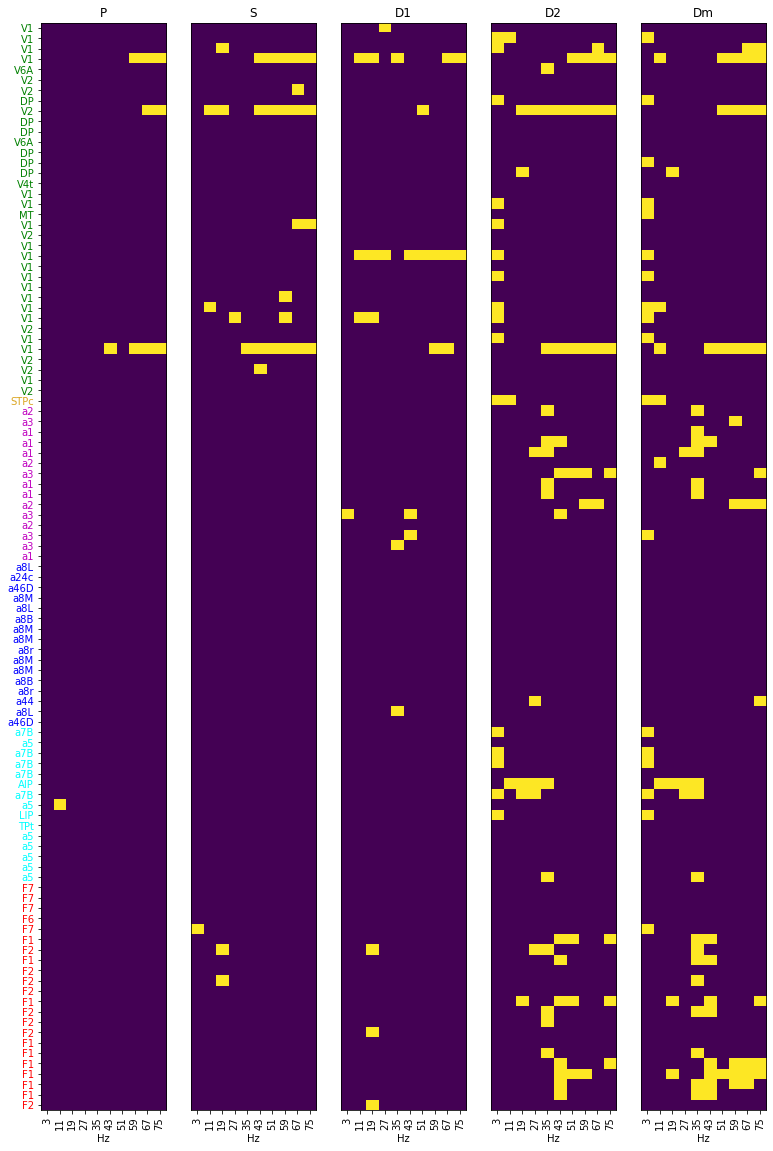

In [31]:
plt.figure(figsize=(13, 20))
plot_tile_maps(crk_pvals, regions)

In [32]:
def plot_power_ts(ax, power, seed=0):
    # Set the seed for the random number generator
    np.random.seed(seed)
    plt.sca(ax)

    # Select 10 random trials from the power data
    it = np.random.choice(range(power.sizes["trials"]), 12)

    power = xr_w_score(power)

    # Calculate the signal entropy for each trial
    H = signal_entropy(power)

    # Select a specific frequency and time range of the data
    power_plot = power.sel(freqs=27, times=slice(-0.5, 2)).isel(roi=33, trials=it)

    # Sort the data by the signal entropy
    times = power_plot.times.data
    ntimes = len(times)
    H = H.sel(freqs=27).isel(roi=33, trials=it)
    idx = np.argsort(H).data[::-1]
    H.values = H.values[idx]
    power_plot.values = power_plot.values[idx]

    # Plot the data
    for i in range(12):
        (power_plot[i] + 3 * i).plot(x="times", hue="trials", color="b", lw=1)
        plt.text(2.1, 3 * i, f"{H[i]:.2f}", fontsize=10)

    plt.vlines(0, -1, 33, color="k", lw=1)
    plt.vlines(0.5, -1, 33, color="k", lw=1)
    plt.vlines(1.5, -1, 33, color="k", lw=1)

    plt.text(1.95, 35, "Norm. H", fontsize=10)

    # ax.get_legend().remove()
    [ax.spines[key].set_visible(False) for key in ["top", "right", "left", "bottom"]]
    plt.axis("off")
    ax.set_title("area 3 (27 Hz power time-series)", pad=0, fontsize=12)


def plot_ent_region(ax, H):
    plt.sca(ax)
    x = H.groupby("roi").median("roi").squeeze()

    for r in np.unique(regions):
        plt.fill_between(
            freqs,
            x.sel(bound="low", roi=r),
            x.sel(bound="high", roi=r),
            alpha=0.4,
            color=colors[r],
            label=r,
        )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=1, fontsize=8)
    plt.xlabel("frequency[Hz]")
    plt.xlim(3, 75)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

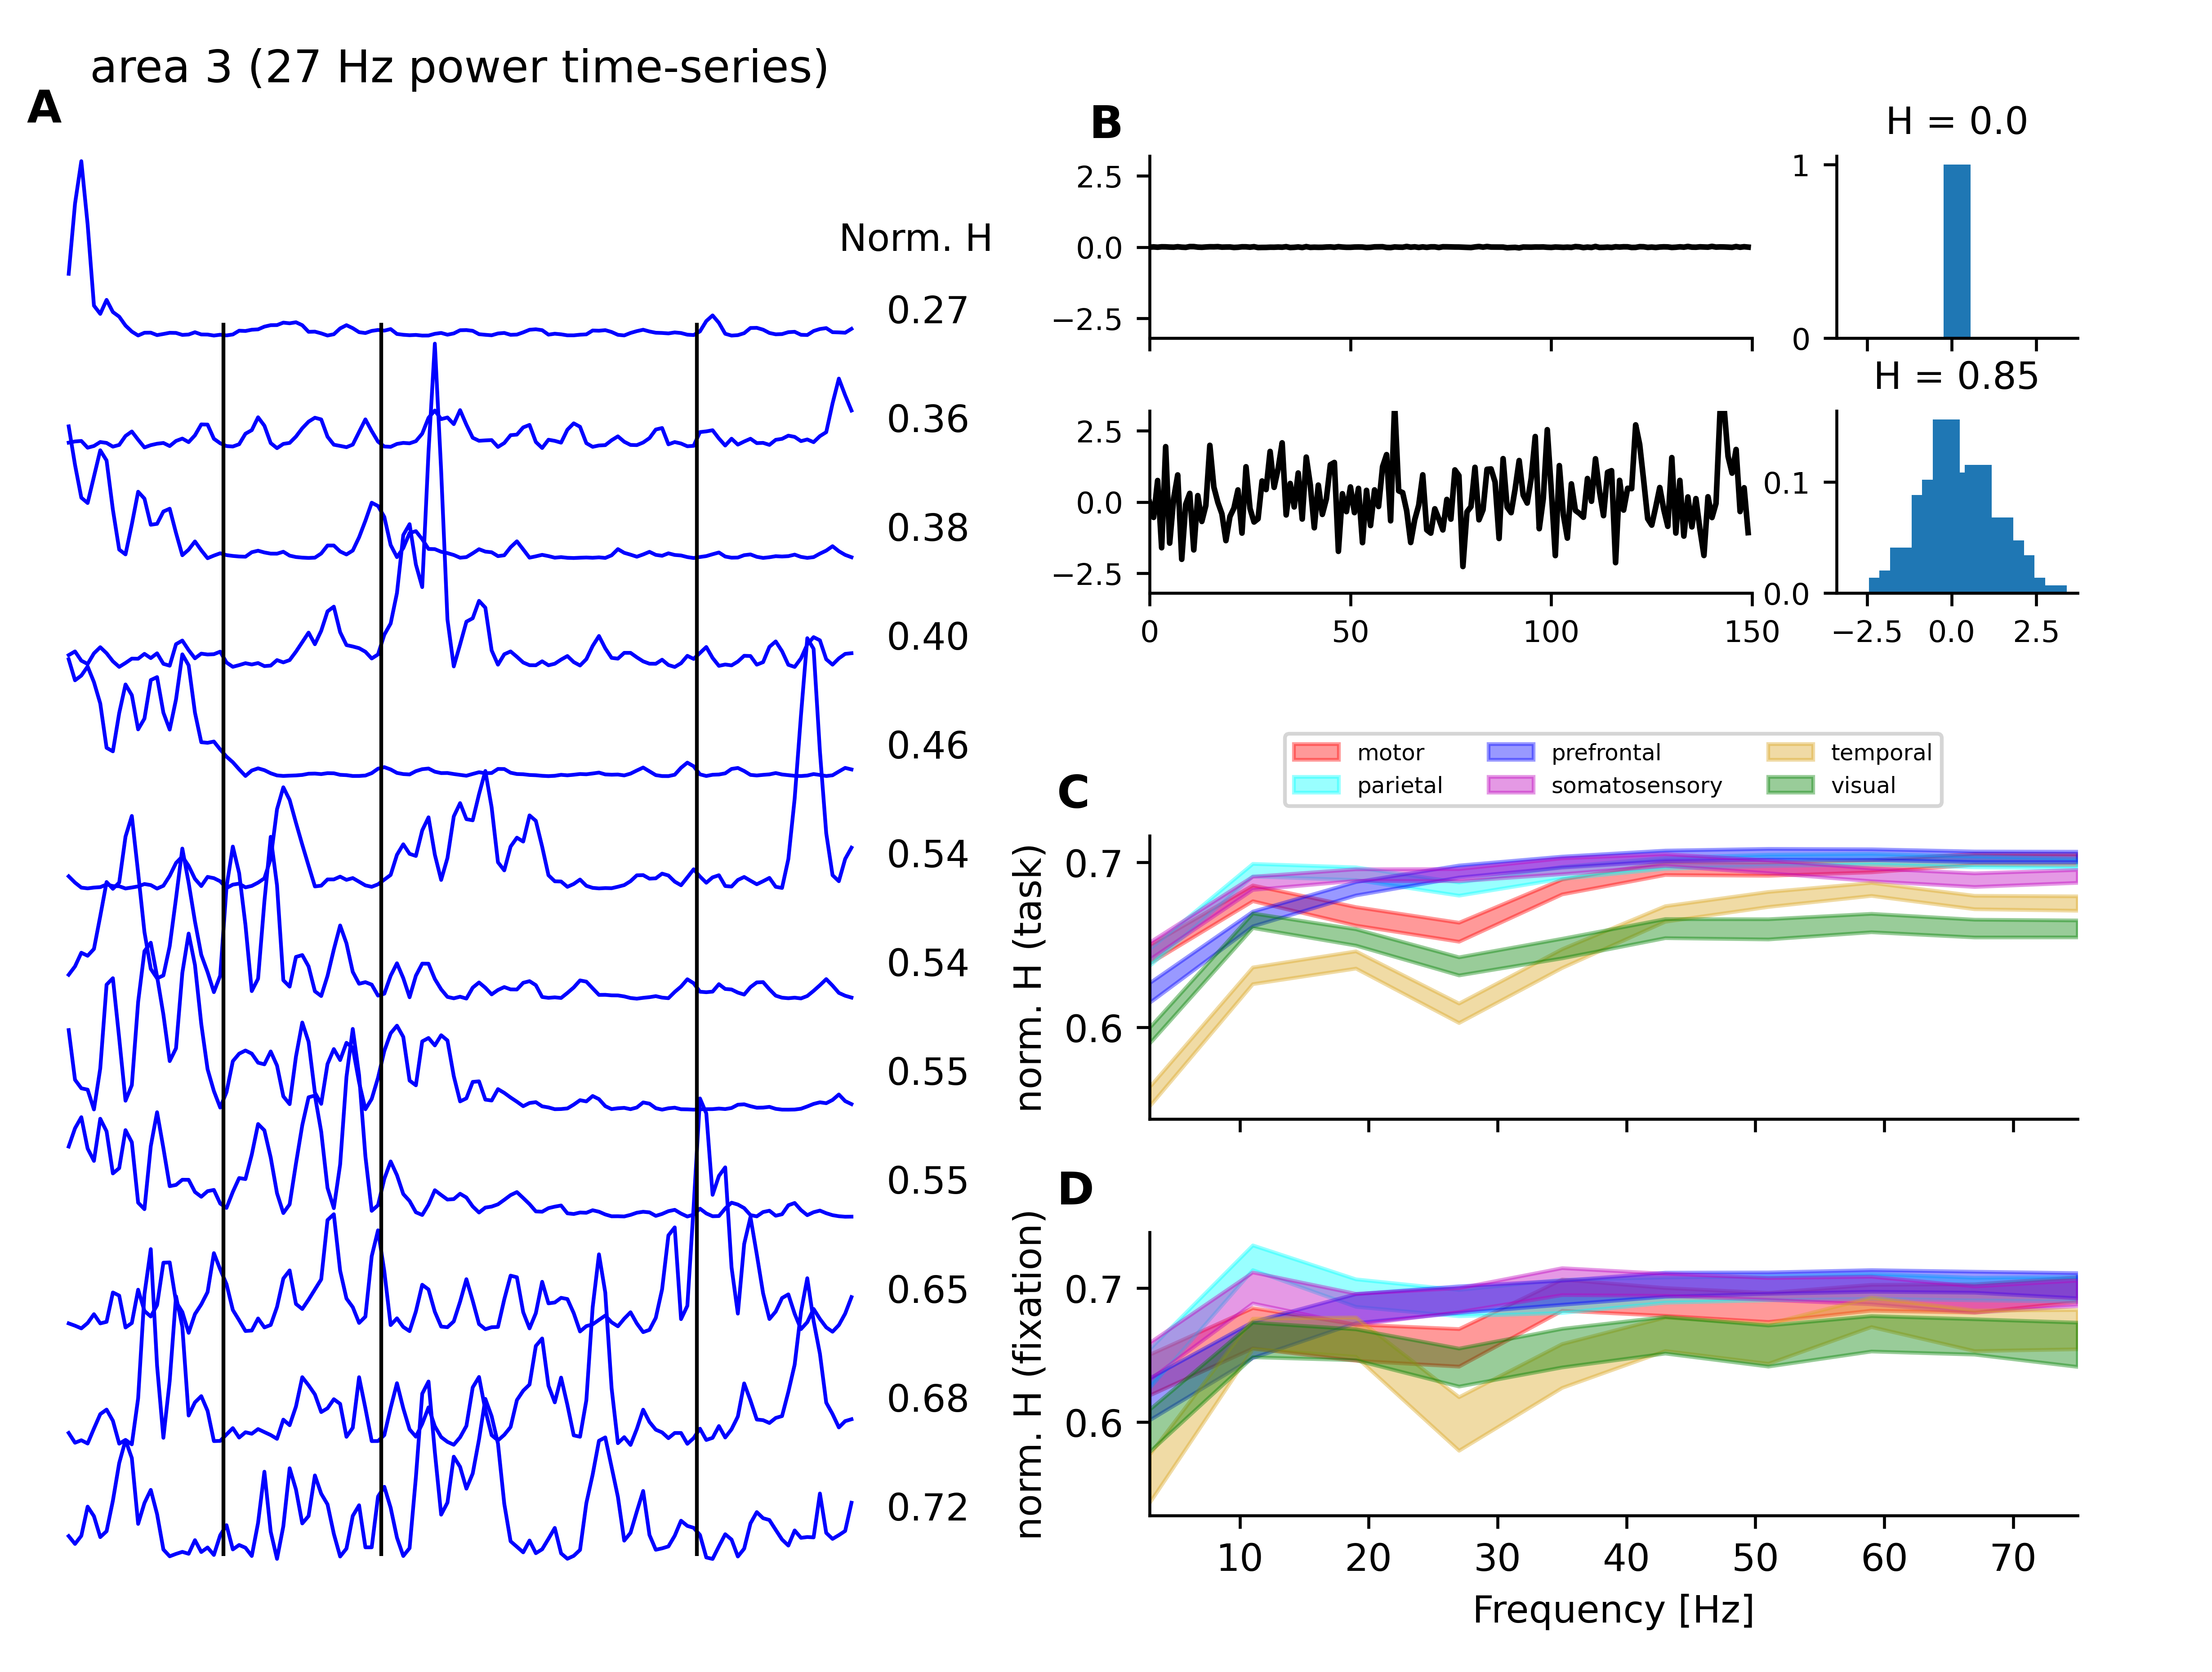

In [33]:
fig = plt.figure(figsize=(8, 6), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.001,
    right=0.4,
    wspace=0,
    bottom=0.01,
    top=0.96,
)

gs1 = fig.add_gridspec(
    nrows=2,
    ncols=2,
    left=0.52,
    right=0.95,
    hspace=0.4,
    bottom=0.65,
    top=0.92,
    wspace=0.2,
    width_ratios=[1, 0.4],
)

gs2 = fig.add_gridspec(
    nrows=2,
    ncols=1,
    left=0.52,
    right=0.95,
    hspace=0.4,
    bottom=0.08,
    top=0.5,
    wspace=0.4,
)

ax0 = plt.subplot(gs0[0])
plot_power_ts(ax0, power_task, seed=100)

ax1 = plt.subplot(gs1[0])
x = np.random.normal(0, 1e-2, size=150)
plt.plot(x, c="k")
plt.ylim(-3.2, 3.2)
plt.xlim([0, 150])
[ax1.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs1[1])
nx, cx = np.histogram(x, bins=np.linspace(-3, 3, 20))
plt.bar(cx[1:], nx / nx.sum())
[ax2.spines[key].set_visible(False) for key in ["top", "right"]]
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
Hx = stats.entropy(nx / nx.sum()) / np.log(20)
plt.title(f"H = {Hx}", fontsize=10)
ax3 = plt.subplot(gs1[2])
y = np.random.normal(0, 1, size=150)
plt.plot(y, c="k")
plt.ylim(-3.2, 3.2)
plt.xlim([0, 150])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
[ax3.spines[key].set_visible(False) for key in ["top", "right"]]
ax4 = plt.subplot(gs1[3])
ny, cy = np.histogram(y, bins=np.linspace(-3, 3, 20))
plt.bar(cx[1:], ny / ny.sum())
[ax4.spines[key].set_visible(False) for key in ["top", "right"]]
Hy = stats.entropy(ny / ny.sum()) / np.log(20)
plt.title(f"H = {Hy:.2f}", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


ax5 = plt.subplot(gs2[0])

x = cv_task.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()

for r in np.unique(regions):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax5.spines[key].set_visible(False) for key in ["top", "right"]]
ax5.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=3, fontsize=6)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.ylabel("norm. H (task)", fontsize=10)

ax6 = plt.subplot(gs2[1])

x = cv_fix.assign_coords({"roi": regions}).groupby("roi").median("roi").squeeze()

for r in np.unique(regions):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.4,
        color=colors[r],
    )
plt.ylabel("norm. H (fixation)", fontsize=10)

plt.xlim(3, 75)
[ax6.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Frequency [Hz]")

bg = plot.Background(visible=False)

plot.add_panel_letters(
    fig,
    axes=[ax0, ax1, ax5, ax6],
    fontsize=12,
    xpos=[-0.003, -0.1, -0.1, -0.1],
    ypos=[0.98, 1.1, 1.1, 1.1],
)

plt.savefig("figures/n1/figure2.pdf")

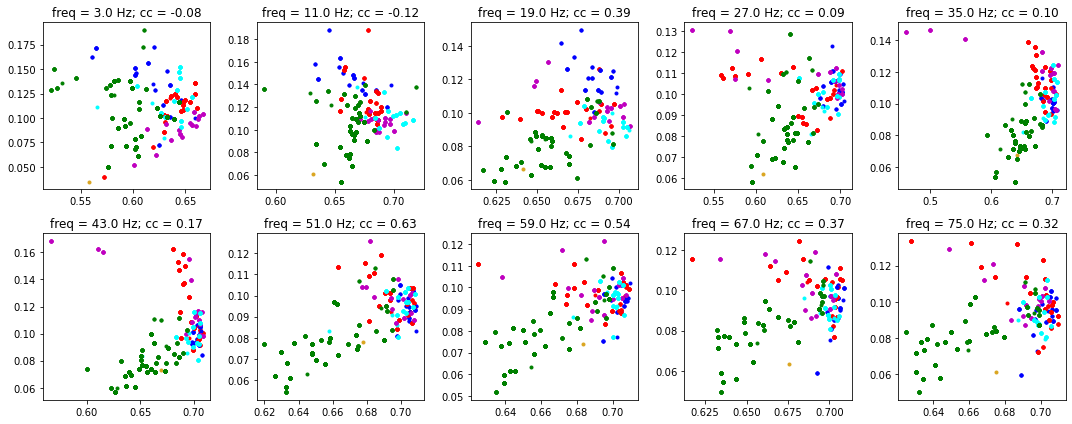

In [34]:
H = signal_entropy(z_power_task)
pc = (power_task >= thr_task).sel(times=slice(0.5, 0.9)).mean("times")

plt.figure(figsize=(15, 6))
for pos, freq in enumerate(H.freqs.data):
    plt.subplot(2, 5, pos + 1)
    for roi in H.roi.data:
        plt.scatter(
            H.sel(freqs=freq).sel(roi=roi).mean("trials"),
            pc.sel(freqs=freq).sel(roi=roi).mean("trials"),
            marker=".",
            color=colors[areas_dict[roi.lower()]],
        )
    cc = np.corrcoef(
        H.sel(freqs=freq).mean("trials").data, pc.sel(freqs=freq).mean("trials")
    )[0, 1]
    plt.title(f"freq = {freq} Hz; cc = {cc:.2f}")
plt.tight_layout()

#### All sessions

In [35]:
cv_fix = []
cv_task = []
for session in tqdm(sessions):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    cv_fix += [compute_time_series_cv(xr_w_score(power_fix))]
    cv_task += [compute_time_series_cv(xr_w_score(power_task))]

100%|██████████| 62/62 [06:19<00:00,  6.11s/it]


In [36]:
cv_fix = node_xr_remove_sca(data_loader.apply_min_rois(cv_fix, 10))
cv_task = node_xr_remove_sca(data_loader.apply_min_rois(cv_task, 10))

In [37]:
rois = cv_task.roi.data

In [38]:
n = np.asarray([areas_dict[roi.lower()] for roi in rois])

In [39]:
cv_task = cv_task.assign_coords(dict(roi=n))
cv_fix = cv_fix.assign_coords(dict(roi=n))

In [40]:
x = cv_task.groupby("roi").median("roi").squeeze()
y = cv_fix.groupby("roi").median("roi").squeeze()

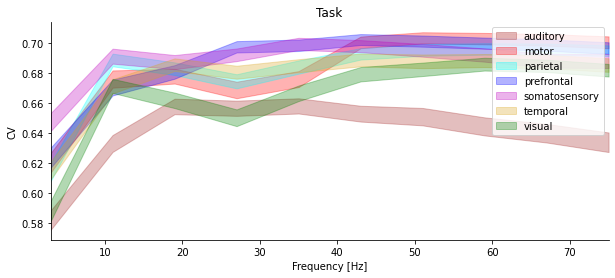

In [41]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        x.sel(bound="low", roi=r),
        x.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
plt.xlabel("Frequency [Hz]")
plt.ylabel("CV")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("Task")
plt.legend()
plt.savefig("figures/n1/cv_all_sessions_task.pdf")

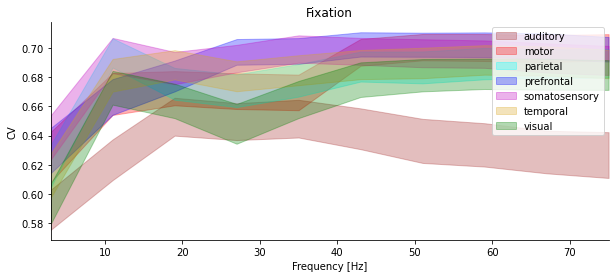

In [42]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for r in np.unique(x.roi.data):

    plt.fill_between(
        freqs,
        y.sel(bound="low", roi=r),
        y.sel(bound="high", roi=r),
        alpha=0.3,
        color=colors[r],
        label=r,
    )
plt.xlim(3, 75)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Frequency [Hz]")
plt.ylabel("CV")
plt.title("Fixation")
plt.legend()
plt.savefig("figures/n1/cv_all_sessions_fixation.pdf")

In [43]:
for f in [11, 27, 67]:

    fig = plt.figure(figsize=(5, 10), dpi=600)

    gs0 = fig.add_gridspec(
        nrows=1,
        ncols=2,
        left=0.05,
        right=0.95,
        wspace=0.1,
        bottom=0.75,
        top=0.95,
        width_ratios=(1.0, 0.1),
    )

    ax1 = plt.subplot(gs0[0])
    if f == 67:
        ax2 = plt.subplot(gs0[1])
    else:
        ax2 = None

    areas = [a.lower() for a in rois]
    values = cv_task.sel(freqs=f).mean("bound").squeeze()
    fmap = flatmap(values.data, areas)

    # Only plot colorbar for last column
    fmap.plot(
        ax1,
        ax_colorbar=ax2,
        cbar_title="Norm. entropy",
        alpha=0.6,
        vmin=0.5,
        vmax=0.7,
        colormap="Greys",
    )
    plt.title(f"{f} Hz")

    plt.savefig(f"figures/n1/{f}hzmap.png", bbox_inches="tight")
    plt.close()

In [581]:
power = []
power_pval = []
crk_pval = []
CC_H_Pc = []
power_sig = []


def compute_for_session(session):

    kw_loader = dict(aligned_at="cue", channel_numbers=False, monkey=monkey)

    power_task = data_loader.load_power(
        **kw_loader, trial_type=1, behavioral_response=1, session=session
    )

    power_fix = data_loader.load_power(
        **kw_loader, trial_type=2, behavioral_response=0, session=session
    )

    power_task = node_xr_remove_sca(power_task)
    power_fix = node_xr_remove_sca(power_fix)

    thr_fix = power_fix.quantile(0.9, ("trials", "times"))
    thr_task = power_task.quantile(0.9, ("trials", "times"))

    raster_fix = []
    raster_task = []
    power_task_mean = []

    for t0, t1 in stages:
        raster_fix += [(power_fix >= thr_fix).sel(times=slice(t0, t1)).mean("times")]
        raster_task += [(power_task >= thr_task).sel(times=slice(t0, t1)).mean("times")]
        power_task_mean += [
            power_task.sel(times=slice(t0, t1)).mean(("times", "trials"))
        ]

    raster_task = xr.concat(raster_task, "times").transpose(*power_task.dims)
    raster_fix = xr.concat(raster_fix, "times").transpose(*power_task.dims)

    power_pval = compute_power_pval(power_task, power_fix, stages)
    crk_pval = compute_crackle_pval(raster_task, raster_fix, stages)

    power_task_mean = xr.concat(power_task_mean, "times").assign_coords(
        {"times": crk_pval.times}
    )

    power_sig = (power_task_mean * crk_pval).to_dataframe("power").reset_index()
    power_sig = power_sig.loc[power_sig.power > 0]
    power_sig["freqs"] = power_sig["freqs"].astype(int)

    cv_task = compute_time_series_cv(xr_w_score(power_task)).squeeze()

    ccs = np.zeros((raster_task.sizes["times"], raster_task.sizes["freqs"]))
    for fi, f in enumerate(raster_task.freqs.data):
        for it, t in enumerate(raster_task.times.data):
            x = cv_task.sel(freqs=f).median("bound")
            y = raster_task.mean("trials").sel(freqs=f, times=it)
            ccs[it, fi] = np.corrcoef(x, y)[0, 1]
    CC_H_Pc = ccs

    power = xr.concat(
        [
            power_task.sel(times=slice(t0, t1)).mean(("times", "trials"))
            for t0, t1 in stages
        ],
        "times",
    )

    ##########################################################################################
    rois = cv_task.roi.data
    areas_dict = get_areas()
    regions = np.asarray([areas_dict[roi.lower()] for roi in rois])
    unique_regions = np.unique(regions)

    x = cv_task.median("bound")
    y = raster_task.mean("trials")

    region2idx = dict(
        motor=0,
        parietal=1,
        prefrontal=2,
        somatosensory=3,
        temporal=4,
        visual=5,
        auditory=6,
    )

    CC_H_Pc_reg = np.zeros((7, 5, 10))

    for fi, freq in enumerate(freqs):
        for t in range(5):
            for ur in unique_regions:
                idx = regions == ur
                CC_H_Pc_reg[region2idx[ur], t, fi] = np.corrcoef(
                    x[idx, fi], y[idx, fi, t]
                )[0, 1]

    return (
        power,
        power_pval,
        crk_pval,
        power_sig,
        CC_H_Pc,
        cv_task,
        raster_task,
        CC_H_Pc_reg,
    )


def compute_for_sessions():

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        compute_for_session, n_jobs=20, verbose=True, total=len(sessions)
    )
    # Compute the single trial coherence
    out = parallel(p_fun(session) for session in sessions)

    power = [out[i][0] for i in range(len(sessions))]
    power_pval = [out[i][1] for i in range(len(sessions))]
    crk_pval = [out[i][2] for i in range(len(sessions))]
    power_sig = [out[i][3] for i in range(len(sessions))]
    CC_H_Pc = [out[i][4] for i in range(len(sessions))]
    cv_task = [out[i][5] for i in range(len(sessions))]
    raster_task = [out[i][6] for i in range(len(sessions))]
    CC_H_Pc_reg = [out[i][7] for i in range(len(sessions))]

    return (
        power,
        power_pval,
        crk_pval,
        power_sig,
        CC_H_Pc,
        cv_task,
        raster_task,
        CC_H_Pc_reg,
    )

In [582]:
(
    power,
    power_pval,
    crk_pval,
    power_sig,
    CC_H_Pc,
    cv_task,
    raster_task,
    CC_H_Pc_reg,
) = compute_for_sessions()

  0%|          |  : 0/62 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   41.1s
[Parallel(n_jobs=20)]: Done  62 out of  62 | elapsed:  1.9min finished


In [583]:
power = data_loader.apply_min_rois(power, 10)
power_pval = data_loader.apply_min_rois(power_pval, 10)
crk_pval = data_loader.apply_min_rois(crk_pval, 10)

In [584]:
power_pval = node_xr_remove_sca(power_pval)
crk_pval = node_xr_remove_sca(crk_pval)

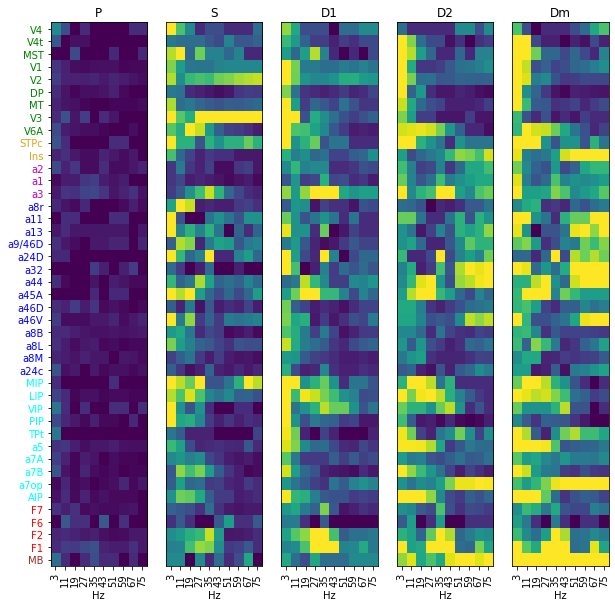

In [585]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    power_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.6,
)
plt.savefig("figures/n1/sig_power.png")

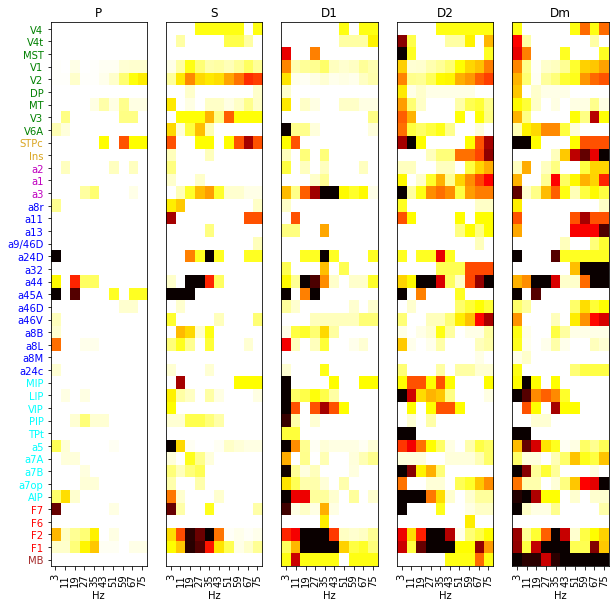

In [586]:
plt.figure(figsize=(10, 10))
plot_tile_maps(
    crk_pval,
    np.asarray([areas_dict[roi.lower()] for roi in power_pval.roi.data]),
    vmin=0,
    vmax=0.3,
    cmap="hot_r",
)
plt.savefig("figures/n1/sig_crackle.png")

In [587]:
def plot_tile_map(ax, values, regions, time, vmin=0, vmax=0.8, cmap="viridis"):
    plt.sca(ax)
    idx = np.argsort(regions)

    freqs = values.freqs

    plt.imshow(
        values.isel(times=time)[idx],
        aspect="auto",
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

    if time == 0:
        tks = plt.yticks(range(len(values.roi)), values.roi.data[idx], fontsize=6)
        [tks[1][j].set_color(colors[r]) for j, r in enumerate(regions[idx])]
    else:
        plt.yticks([])

    freq_ticks = ["", "11", "", "27", "", "43", "", "59", "", "75"]

    plt.xticks(range(len(freqs)), freq_ticks, rotation=90, fontsize=5)
    plt.xlabel("Hz", fontsize=6)
    plt.title(f"{values.times[time].data}", fontsize=8)

    ax.grid(which="minor", color="grey", linestyle="-", linewidth=2)

In [588]:
def plot_ent_region(ax, H):
    plt.sca(ax)
    x = H.groupby("roi").median("roi").squeeze()
    x_med = x.median("bound")
    err = (x.sel(bound="high") - x.sel(bound="low")) / 2
    for r in np.unique(regions):
        plt.errorbar(
            freqs,
            x_med.sel(roi=r),
            err.sel(roi=r),
            fmt="s",
            capsize=3,
            color=colors[r],
            label=r,
        )
        
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.4), ncol=3, fontsize=8)
    plt.xlabel("frequency[Hz]")
    plt.xlim(2, 80)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [589]:
def plot_power_dist(ax, thr):
    df = pd.concat(power_sig)

    sns.boxplot(data=df, x="freqs", y="power", color="lightblue", showfliers=False)
    ax.set(yscale="log")
    plt.ylabel("log(power)", fontsize=8)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.xlabel("frequency [Hz]", fontsize=8)
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)

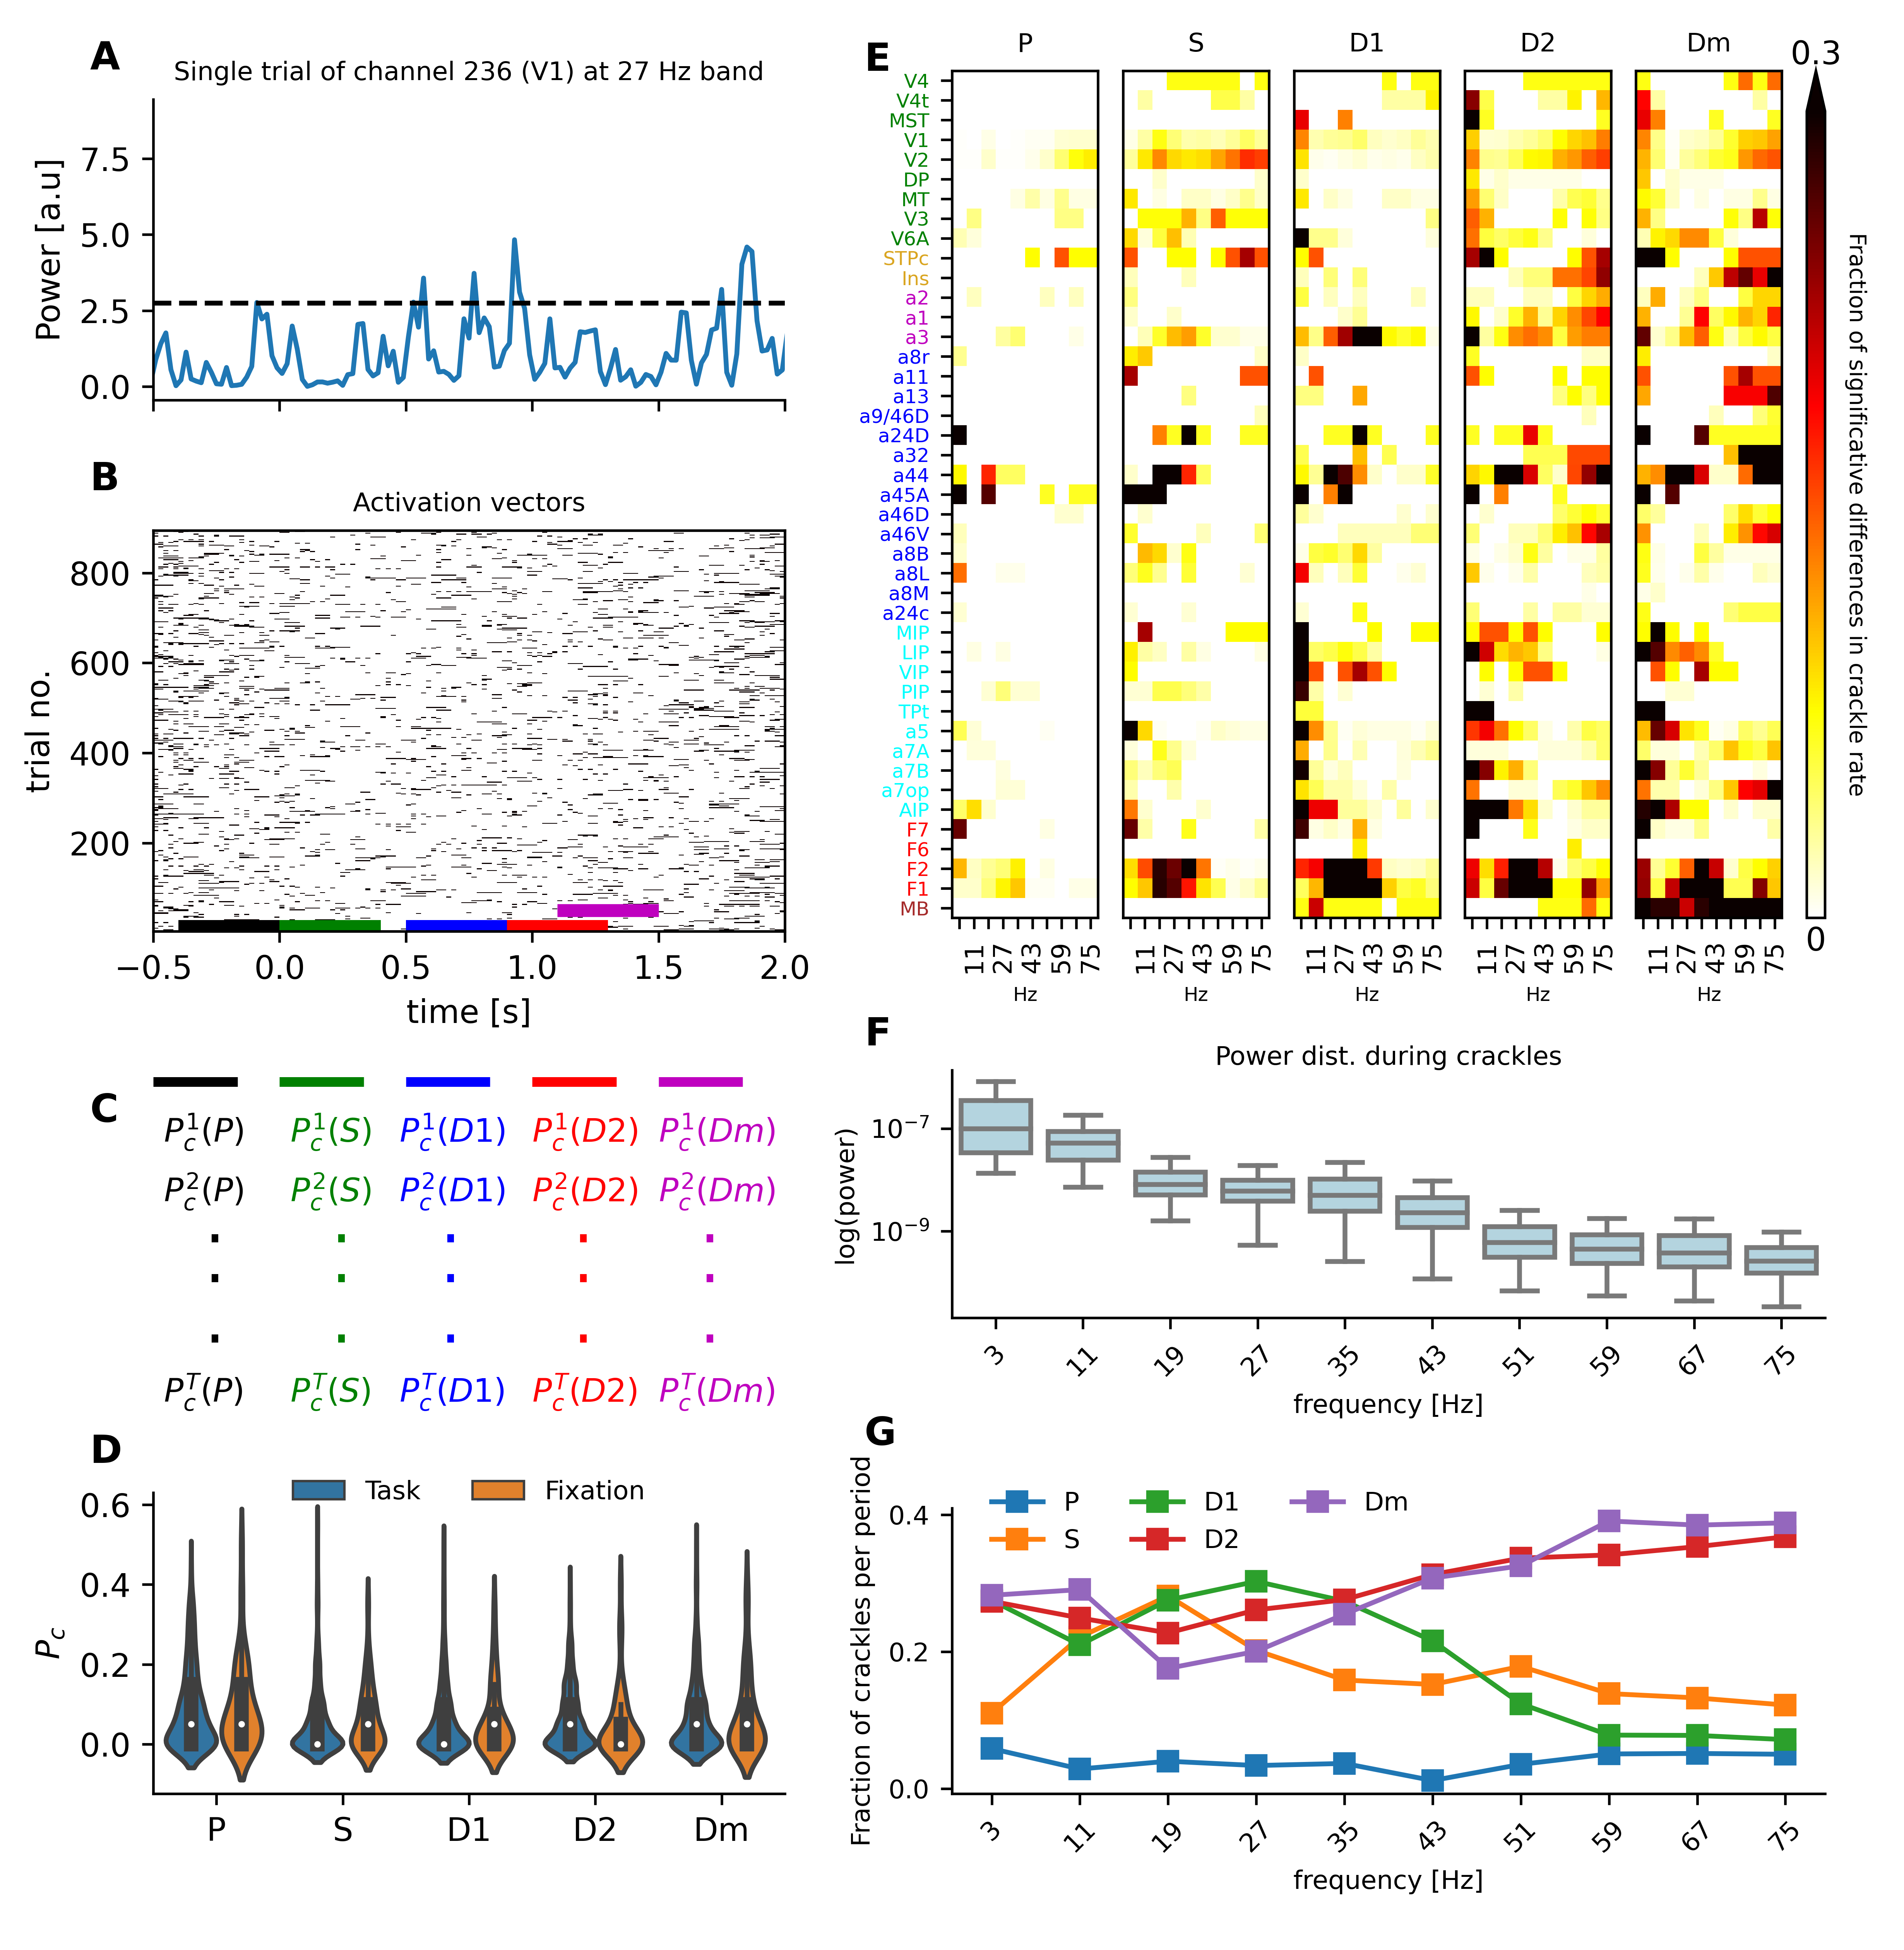

In [590]:
fig = plt.figure(figsize=(8.0, 8.2), dpi=600)

gs0 = fig.add_gridspec(
    nrows=4,
    ncols=1,
    left=0.07,
    right=0.41,
    hspace=0.4,
    bottom=0.07,
    top=0.96,
    height_ratios=[0.3, 0.4, 0.3, 0.3],
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=6,
    left=0.5,
    right=0.97,
    wspace=0.2,
    bottom=0.53,
    top=0.975,
    width_ratios=[0.8, 0.8, 0.8, 0.8, 0.8, 0.1],
)

gs2 = fig.add_gridspec(
    nrows=1, ncols=1, left=0.5, right=0.97, wspace=0.2, bottom=0.32, top=0.45
)

gs3 = fig.add_gridspec(
    nrows=1, ncols=1, left=0.5, right=0.97, wspace=0.2, bottom=0.07, top=0.22
)

ax0 = plt.subplot(gs0[0])
thr_v1 = thr_task.sel(freqs=27).isel(roi=-1) * 1e9
power_v1 = power_task.isel(roi=-1).sel(freqs=27) * 1e9
raster_v1 = power_v1 >= thr_v1
power_v1.isel(trials=0).plot(x="times")
[ax0.spines[key].set_visible(False) for key in ["top", "right"]]

plt.setp(ax0.get_xticklabels(), visible=False)
plt.ylabel("Power [a.u]")
plt.hlines(thr_v1, -0.5, 2, color="k", linestyle="--")
plt.xlim(-0.5, 2)
plt.xlabel("")
plt.title("Single trial of channel 236 (V1) at 27 Hz band", fontsize=8)
ax1 = plt.subplot(gs0[1])
raster_v1.plot.imshow(x="times", y="trials", cmap="hot_r", add_colorbar=False)
plt.xlim(-0.5, 2)
plt.ylabel("trial no.")
plt.title("")
ax1.hlines(7, -0.4, 0, lw=6, color="k")
ax1.hlines(7, 0, 0.4, lw=6, color="g")
ax1.hlines(7, 0.5, 0.9, lw=6, color="b")
ax1.hlines(7, 0.9, 1.3, lw=6, color="r")
ax1.hlines(50, 1.1, 1.5, lw=4, color="m")
plt.xlabel("time [s]")
plt.title("Activation vectors", fontsize=8)
ax3 = plt.subplot(gs0[2])
# plt.axis("off")
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1)
ax3.hlines(0.9, -0.5, -0.1, lw=3, color="k")
ax3.hlines(0.9, 0.1, 0.5, lw=3, color="g")
ax3.hlines(0.9, 0.7, 1.1, lw=3, color="b")
ax3.hlines(0.9, 1.3, 1.7, lw=3, color="r")
ax3.hlines(0.9, 1.9, 2.3, lw=3, color="m")

xs = [-0.45, 0.15, 0.67, 1.3, 1.9]
sl = ["P", "S", "D1", "D2", "Dm"]
cl = ["k", "g", "b", "r", "m"]

for i in range(5):
    plt.text(xs[i], 0.6, f"$P_c^1({sl[i]})$", color=cl[i])
    plt.text(xs[i], 0.3, f"$P_c^2({sl[i]})$", color=cl[i])
    plt.text(xs[i], 0.1, f"  .", color=cl[i], fontsize=20)
    plt.text(xs[i], -0.1, f"  .", color=cl[i], fontsize=20)
    plt.text(xs[i], -0.4, f"  .", color=cl[i], fontsize=20)
    plt.text(xs[i], -0.7, f"$P_c^T({sl[i]})$", color=cl[i])
plt.axis("off")

ax4 = plt.subplot(gs0[3])
thr_v1_fix = thr_fix.sel(freqs=27).isel(roi=-1) * 1e9
power_v1_fix = power_fix.isel(roi=-1).sel(freqs=27) * 1e9
raster_v1_fix = power_v1_fix >= thr_v1_fix

df_task = []
df_fix = []

for i, (t0, t1) in enumerate(stages):
    df_task += [
        raster_v1.sel(times=slice(t0, t1))
        .mean("times")
        .to_dataframe("Pc")
        .reset_index()
    ]
    df_task[-1]["times"] = stage_labels[i]
    df_fix += [
        raster_v1_fix.sel(times=slice(t0, t1))
        .mean("times")
        .to_dataframe("Pc")
        .reset_index()
    ]
    df_fix[-1]["times"] = stage_labels[i]

df_task = pd.concat(df_task)
df_fix = pd.concat(df_fix)

df_task["task"] = "Task"
df_fix["task"] = "Fixation"

df = pd.concat([df_task, df_fix])

sns.violinplot(data=df, x="times", y="Pc", showfliers=False, hue="task", trim=True)
plt.xlabel("")
plt.ylabel(r"$P_c$")
[ax4.spines[key].set_visible(False) for key in ["top", "right"]]
ax4.legend(
    loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=2, fontsize=8, frameon=False
)


################################################## ALL SESSIONS ##################################################
axs = [plt.subplot(gs1[i]) for i in range(6)]

for time, ax in enumerate(axs[:-1]):

    plt.sca(ax)

    plot_tile_map(
        ax,
        crk_pval,
        np.asarray([areas_dict[roi.lower()] for roi in crk_pval.roi.data]),
        time,
        vmin=0,
        vmax=0.3,
        cmap="hot_r",
    )

    plt.xticks(fontsize=8)


import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.3)
cmap = matplotlib.cm.get_cmap("hot_r")


cbar = plt.colorbar(
    mappable=plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ticks=[],
    cax=axs[5],
    extend="max",
)
cbar.ax.set_ylabel(
    "Fraction of significative differences in crackle rate",
    fontsize=7,
    rotation=270,
    labelpad=13,
)

cbar.ax.text(0.5, -0.01, "0", transform=cbar.ax.transAxes, va="top", ha="center")
cbar.ax.text(0.5, 1.05, "0.3", transform=cbar.ax.transAxes, va="bottom", ha="center")


##################################################################################################################
ax5 = plt.subplot(gs2[0])
plot_power_dist(ax5, 0)
plt.title("Power dist. during crackles", fontsize=8, pad=-1)

ax6 = plt.subplot(gs3[0])
frac = []
out = pd.concat(power_sig)
for freq in freqs:
    rois = out.loc[out.freqs == freq].times.values
    vals, counts = np.unique(rois, return_counts=True)
    counts = counts / counts.sum()
    frac += [
        xr.DataArray(counts, dims=("times"), coords=dict(times=vals)).sel(
            times=stage_labels
        )
    ]
frac = xr.concat(frac, "freqs").assign_coords(dict(freqs=freqs))
[plt.plot(frac.isel(times=i), marker="s", label=stage_labels[i]) for i in range(5)]
plt.xticks(range(10), freqs.astype(int))
ax6.legend(loc="right", bbox_to_anchor=(0.55, 0.95), ncol=3, fontsize=8, frameon=False)
[ax6.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("frequency [Hz]", fontsize=8)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("Fraction of crackles per period", fontsize=8)

plot.add_panel_letters(
    fig,
    axes=[ax0, ax1, ax3, ax4, axs[0], ax5, ax6],
    fontsize=12,
    xpos=[-0.1, -0.1, -0.1, -0.1, -0.6, -0.1, -0.1],
    ypos=[1.1, 1.1, 0.8, 1.1, 1, 1.1, 1.22],
)

bg = plot.Background(visible=False)

plt.savefig("figures/n1/figure3.pdf")

In [591]:
CC_H_Pc = xr.DataArray(
    CC_H_Pc,
    dims=("sessions", "times", "freqs"),
    coords=dict(sessions=sessions, times=stage_labels, freqs=freqs),
)

In [592]:
region_names = [
    "motor",
    "parietal",
    "prefrontal",
    "somatosensory",
    "temporal",
    "visual",
]

In [593]:
CC_H_Pc_reg = xr.DataArray(
    np.stack(CC_H_Pc_reg, 0),
    dims=("sessions", "regions", "times", "freqs"),
    coords=(sessions, regions, stage_labels, freqs),
)

ValueError: conflicting sizes for dimension 'regions': length 7 on the data but length 105 on coordinate 'regions'

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(8.3, 8), dpi=600)

gs0 = fig.add_gridspec(
    nrows=1,
    ncols=5,
    left=0.07,
    right=0.97,
    wspace=0.35,
    bottom=0.8,
    top=0.95,
)

gs1 = fig.add_gridspec(
    nrows=1,
    ncols=1,
    left=0.07,
    right=0.97,
    wspace=0.35,
    bottom=0.45,
    top=0.7,
)

gs2 = fig.add_gridspec(
    nrows=2,
    ncols=3,
    left=0.07,
    right=0.93,
    hspace=0.35,
    wspace=0.1,
    bottom=0.05,
    top=0.37,
)

axs0 = [plt.subplot(gs0[i]) for i in range(5)]

cc = confidence_interval(CC_H_Pc, axis=0, n_boots=500).squeeze()

rois = cv_task[5].roi.data
regions = np.asarray([areas_dict[roi.lower()] for roi in rois])
unique_regions = np.unique(regions)
x = cv_task[5].median("bound").sel(freqs=slice(27, 35))

for i in range(5):
    plt.sca(axs0[i])
    y = raster_task[5].sel(freqs=slice(27, 35), times=i).mean("trials")
    for ur in unique_regions:
        idx = regions == ur
        sns.regplot(
            x=x[idx].data.flatten(),
            y=y[idx].data.flatten(),
            n_boot=5000,
            color=colors[ur],
            ci=None,
            line_kws={"lw": 1},
            scatter_kws={"s": 5},
            label=ur,
        )
    if i == 0:
        plt.ylabel(r"$P_c$", fontsize=10)
    plt.xlabel("norm. H", fontsize=10)
    if i == 2:
        axs0[i].legend(
            loc="upper center",
            bbox_to_anchor=(0.55, 1.3),
            ncol=6,
            fontsize=8,
            frameon=False,
        )
    [axs0[i].spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"{stage_labels[i]}", fontsize=8, pad=1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    axs0[i].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

axs1 = plt.subplot(gs1[0])
cc.median("bound").plot(x="freqs", hue="times")
for i in range(5):
    plt.fill_between(
        freqs,
        cc.sel(bound="low").isel(times=i),
        cc.sel(bound="high").isel(times=i),
        alpha=0.4,
        label=stage_labels[i],
    )
plt.xticks(freqs.astype(int), fontsize=10)
plt.xlim(3, 75)
plt.ylabel(r"CC$(H, P_c)$", fontsize=10, labelpad=-1)
plt.xlabel(r"frequency [Hz]", fontsize=10)
[axs1.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("CI of CC$(H, P_c)$ across sessions", fontsize=10)
axs1.legend(
    loc="upper center", bbox_to_anchor=(0.15, 1), ncol=3, fontsize=8, frameon=False
)

axs2 = [plt.subplot(gs2[i]) for i in range(6)]

cc_reg = confidence_interval(CC_H_Pc_reg, axis=0, n_boots=500).squeeze()

for pos, region in enumerate(region_names):
    plt.sca(axs2[pos])
    cc_reg.sel(regions=region).median("bound").plot(x="freqs", hue="times")
    for t in stage_labels:
        plt.fill_between(
            freqs,
            cc_reg.sel(regions=region, bound="low", times=t),
            cc_reg.sel(regions=region, bound="high", times=t),
            alpha=0.4,
            label=t
        )
    [axs2[pos].spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(region, fontsize=10, pad=-1)
    if pos in [0, 1, 2]:
        plt.setp(axs2[pos].get_xticklabels(), visible=False)
        plt.xlabel("")
    else:
        plt.xlabel("frequency [Hz]", fontsize=8)
        plt.xticks(freqs.astype(int))
    if pos not in [0, 3]:
        plt.setp(axs2[pos].get_yticklabels(), visible=False)
        plt.ylabel("")
    else:
        plt.ylabel(r"CC$(H, P_c)$", fontsize=8, labelpad=-1)
    if pos == 2:
        axs2[pos].legend(
            loc="upper center",
            bbox_to_anchor=(1.15, 0.35),
            ncol=1,
            fontsize=8,
            frameon=False,
        )
    else:
        axs2[pos].get_legend().remove()
    plt.xlim(3, 75)
    
plot.add_panel_letters(
    fig,
    axes=[axs0[0], axs1, axs2[0], axs2[1], axs2[2], axs2[3], axs2[4], axs2[5]],
    fontsize=12,
    xpos=[-0.2, -0.03, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1],
    ypos=[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1],
)


bg = plot.Background(visible=False)

plt.savefig("figures/n1/figure4.pdf")